In [1]:
import matplotlib.pyplot as plt


In [2]:
def set_figsize():
    plt.figure(figsize=(7, 5))
    plt.rcParams['font.size'] = 12

In [16]:
import numpy as np
import seaborn as sn

filesizes = ['5', '10', '17', '25', '32', '40', '50', '60', '75', '100']
categories = ['AVIF', 'BPG', 'HEIC', 'JPEG', 'JPEG2000', 'JPEG_XL', 'JPEG_XR_0', 'JPEG_XR_1', 'JPEG_XR_2', 'WEBP']

set_figsize()
# mixed model
# load dic from file
mixed_results_5_to_100 = np.load('results/conf_matrix_fs_all_model.npy', allow_pickle=True).tolist()
cmap = plt.get_cmap('tab20')

for fs in filesizes:
    #sn.set(font_scale=1.4)
    sn.heatmap(mixed_results_5_to_100[fs], vmin=0, vmax=100,
               xticklabels=categories,
               yticklabels=categories,
               annot=True,
               cmap='Blues',
               fmt=".0f")
    plt.xticks(rotation=45)
    plt.savefig(f'Plots/conf_matrix/mixed_5_to_100/conf_matrix_mixed_model_5_to_100_fs_{fs}.pgf')
    plt.close()



In [18]:

# mixed model
# load dic from file
mixed_results_5_to_100 = np.load('results/conf_matrix_all_fs_all_model.npy', allow_pickle=True).tolist()
cmap = plt.get_cmap('tab20')

set_figsize()
#sn.set(font_scale=1.4)
sn.heatmap(mixed_results_5_to_100, vmin=0, vmax=1000,
           xticklabels=categories,
           yticklabels=categories,
           annot=True,
           cmap='Blues',
           fmt=".0f")
plt.xticks(rotation=45)
plt.savefig('Plots/conf_matrix/mixed_5_to_100/conf_matrix_mixed_model_5_to_100_fs_all.pgf')
plt.close()

        filesize  target    codec
40000  35.722656      40  JPEG_XL
40001  38.945312      40  JPEG_XL
40002  11.196289       5  JPEG_XL
40003  82.772461     100  JPEG_XL
40004  31.744141      32  JPEG_XL
...          ...     ...      ...
40095   9.570312      10  JPEG_XL
40096   9.973633      10  JPEG_XL
40097   9.851562      10  JPEG_XL
40098   9.657227      10  JPEG_XL
40099   9.754883      10  JPEG_XL

[100 rows x 3 columns]


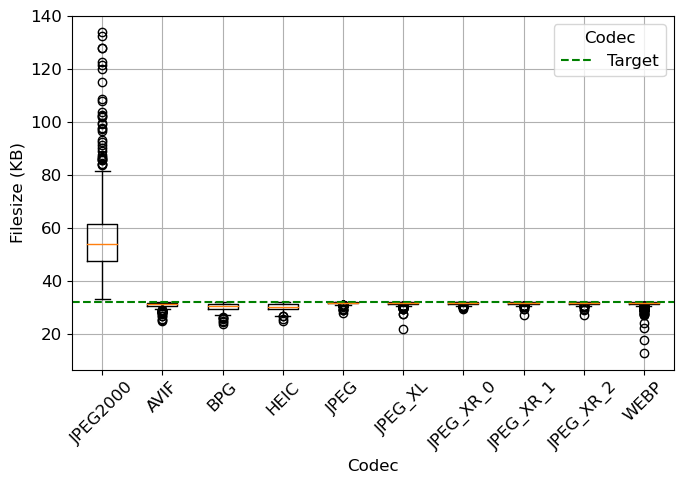

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def set_figsize():
    plt.figure(figsize=(7, 5))
    plt.rcParams['font.size'] = 12

def plot_filesize_to_target():
    # read csv
    df = pd.read_csv('filesize_log.txt', sep=',', header=None)
    df.columns = ['filesize', 'target', 'codec']

    # sort by string in codec column and reset index
    df = df.sort_values(by=['codec']).reset_index(drop=True)
    # remove / from codec column
    df['codec'] = df['codec'].str.replace('/', '').str.upper().str.strip()

    print(df[40000:40100])
    # select only the rows where the target is 32
    df = df[df['target'] == 32]

    # pritn the types of the df
    # select only JPEG2000
    #df = df[df['codec'] == 'JPEG2000']

    # scatter plot with each codec in different color with filesize as y and index as x
    set_figsize()
    # plt df with a color for each codec
    label = df['codec'].unique()
    # box plot
    plot = plt.boxplot([df[df['codec'] == label]['filesize'] for label in label], labels=label)

    # for i, label in enumerate(label):
    #    plt.scatter(df[df['codec'] == label].index, df[df['codec'] == label]['filesize'], label=label)
    # plot line at target value
    plt.axhline(y=32, color='green', linestyle='--', label='Target')
    # legend
    plt.legend(title='Codec')
    plt.grid()
    plt.xlabel('Codec')
    plt.ylabel('Filesize (KB)')
    plt.xticks(rotation=45)
    # Use tight_layout to ensure all elements fit within the saved area
    plt.tight_layout()
    plt.show()

plot_filesize_to_target()


# read in file size log file and remove all rows with codec 'JPEG2000'
# df = pd.read_csv('filesize_log.txt', sep=',', header=None)
# df.columns = ['filesize', 'target', 'codec']
# df['codec'] = df['codec'].str.replace('/', '').str.upper().str.strip()
# df = df[df['codec'] != 'JPEG2000']
# # add a / to the codec column
# df['codec'] = df['codec'] + '/'
# df.to_csv('filesize_log_2.txt', index=False, header=False)

In [2]:
import torch
from sklearn.metrics import precision_recall_fscore_support
from torch import nn
from torchvision import transforms, models
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import scripts.cnnDataset as cnnDataset


def evaluate_model(model, test_loader):
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )

    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            print(images)

            outputs = model(images)
            # l2 norm
            outputs = nn.functional.normalize(outputs, p=2, dim=1)

            all_preds.append((outputs.cpu().numpy()))
            all_labels.extend(labels.cpu().numpy())

    # make a single numpy array from list of arrays
    all_preds = np.concatenate(all_preds)
    # scatter plot all_preds color coded by all_labels
    # all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    # all_preds = all_preds.reshape(all_preds.shape[0], all_preds.shape[2])
    pca = PCA(n_components=2)
    pca.fit(all_preds)
    all_preds = pca.transform(all_preds)

    # set label to name from dataloader
    all_labels = np.array([test_loader.dataset.classes[label] for label in all_labels])
    # relpace underscores with spaces
    all_labels = np.array([label.replace('_', ' ') for label in all_labels])
    # replace '0' with {0} and '1' with {1} and '2' with {2}
    all_labels = np.array([label.replace(' 0', '_{0}') for label in all_labels])
    all_labels = np.array([label.replace(' 1', '_{1}') for label in all_labels])
    all_labels = np.array([label.replace(' 2', '_{2}') for label in all_labels])
    # relpace JPEG2000 with JPEG 2000
    all_labels = np.array([label.replace('JPEG2000', 'JPEG 2000') for label in all_labels])

    return all_preds, all_labels


def main():
    # filesizes = ['5', '10', '17', '25', '32', '40', '50', '60', '75', '100']
    filesizes = ['10']

    result_dictionary = {
        '5': 0,
        '10': 0,
        '17': 0,
        '25': 0,
        '32': 0,
        '40': 0,
        '50': 0,
        '60': 0,
        '75': 0,
        '100': 0
    }

    for filesize in filesizes:
        transform = transforms.Compose([
            # the model excepts just 224x224 images, maybe we need to crop our images before encoding them
            # I used crop, resize would change the image and therefore can lead to probles for our classification
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        _, val_loader = cnnDataset.create_dataset(transform=transform, filesize=filesize)

        model_name = 'resnet18'
        model = models.resnet18()

        print('Evaluate pretrained model ( ' + model_name + ' ) with Filesize = ' + filesize + ' kB')
        result_dictionary[filesize] = evaluate_model(model, val_loader)

        # store the results in a file
        np.save(f'results/wo_transfer_results.npy', result_dictionary)


if __name__ == '__main__':
    main()


Evaluate pretrained model ( resnet18 ) with Filesize = 10 kB


KeyboardInterrupt: 

In [18]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import plotly.express as px
results = np.load('results/wo_transfer_results.npy', allow_pickle=True).item()
print(results.keys())
all_preds = np.array(results['10'][0])
all_labels = np.array(results['10'][1])
image_names = np.array(results['10'][2])
# only get the first value of the tuple
# take the first five predictions of each codec
indices = []
for label in np.unique(all_labels):
    indices += list(np.where(all_labels == label)[0][:])
indices = np.array(indices)
all_preds = all_preds[indices]
all_labels = all_labels[indices]
image_names = image_names[indices]
# create a df with the data
df = pd.DataFrame(all_preds, columns=['PC1', 'PC2'])
df['label'] = all_labels
# Extract only the filename from image_names
filenames = [os.path.basename(image[0]) for image in image_names]
df['image'] = filenames
path_names = [image[0] for image in image_names]

fig = px.scatter(df, x='PC1', y='PC2', color='label')
for x,y,png in zip(fig.data[0]['x'], fig.data[0]['y'], path_names):
    fig.add_layout_image(
        dict(
            source=png,
            x=x,
            y=y,
            xref="x",
            yref="y",
            sizex=0.05,
            sizey=0.05,
            opacity=0.8,
            xanchor="center",
            yanchor="middle")
    )
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=True)
fig.show()

# # get all unique labels
# unique_labels = np.unique(all_labels)
# markers = ['o', 'x', 's', 'D', '^', 'v', '<', '>', 'p', 'h']
# fig, ax = plt.subplots()
# for i in range(len(unique_labels[0])):
#     x = all_preds[all_labels == unique_labels[i], 0]
#     y = all_preds[all_labels == unique_labels[i], 1]
#     ax.scatter(x, y, label=unique_labels[i], marker=markers[i])
#     print(x)
#     for j, txt in enumerate(image_names):
#         print(j)
#         print(txt)
#         ax.annotate(txt, (x[j], y[j]))
# plt.legend()
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()


dict_keys(['5', '10', '17', '25', '32', '40', '50', '60', '75', '100'])
